# Trading Bot through pattern recognition with ML


## Introduction


Along this notebook, I'm going to detail the design of a trading bot through a Machine Learning algorithm. This ML-algo will have different stages, that will act as a waterfall process, where the result of one stage will feed the next one, and so on.

These are the main stages (detailed on next sections), in which the ML-algo is divided:

- A pattern recognition submodule, to identify different market conditions.
- A RL-agent, to forecast price movements in short-term future, from market conditions generated by the previous stage.
- A RL-agent, to setup and execute long-short operations with stoploss, takeprofit and partial-close levels; from the forecast generated by the previous agent.


## Market conditions

Financial instruments always move in zigzag sequences, forming 3 kinds of trends as the [Elliott Waves theory](https://stockcharts.com/school/doku.php?id=chart_school:market_analysis:introduction_to_elliott_wave_theory) explains:
<img src="https://d.stockcharts.com/school/data/media/chart_school/market_analysis/introduction_to_elliott_wave_theory/wave8.png" alt="Drawing" style="width: 400px;"/>

Along those zigzags different market conditions can be observed:

- Bullish trends: where the price goes higher
- Lateral channels: where the price fluctuates between a more or less defined range.
- Bearish trends: where the price goes lower

Also, is common that price can vary between a well defined channel, as shown below:
<img src="https://bpcdn.co/images/2016/05/grade1-channel-thumbnail.png" alt="Drawing" style="width: 400px;"/>

So, areas near the channel's limits are critical, because price can twist to the other side or break the channel to start a lateral range or a change of trend.

For those reasons, the pattern recognition submodule will observe one or more candlestick charts of a financial instrument with the help of several indicators (like MACD, Bollinger, ...) to generate an estimation of the current market condition.

<img src="img/market-condition-generator.jpg" alt="Drawing" style="width: 400px;"/>

This submodule will produce a combination of variables that in turn will form the market condition identification:

- _**MainTrend**_: provides information about the main trend of the price. It is formed by 3 parameters:
    - ```Direction```: indicates trend direction:
        - ```Bullish```: indicates the probability that a bullish trend is in course, providing a percentage degree of assurance (0-100%).
        - ```Bearish```: indicates the probability that a bearish trend is in course (0-100%).
        - ```Lateral```: indicates the probability that a lateral range is in course (0-100%).
    - ```State```: indicates the state of the trend:
        - ```Start```: indicates that the trend is starting.
        - ```Hold```: indicates the trend is going on.
        - ```End```: indicates the trend is finishing.

- _**Channel**_: provides information about the probability that a channel has been formed:
    - ```IsFormed```: indicates the probability that the channel is formed (0-100%).
    - ```Range```: channel's range in pips
    - ```Inclination```: channel's inclination in degrees
    - ```BottomLine```: points (x0,y0), (x1,y1) of the channel's bottom line
    - ```TopLine```: points (x0,y0), (x1,y1) of the channel's top line
    - ```PriceAt```: indicates the relative position of the price in the channel. If price is at the bottom line it takes a value of 0% and if it is at the top line it takes a value of 100%.
    - ```StUp```: indicates the probability that the price si going up inside the channel (pullbacks in bearish trends).
    - ```StDown```: indicates the probability that the price si going down inside the channel (pullbacks in bullish trends).
    - ```StLateral```: indicates the probability that the price si moving laterally along the channel.
    - ```StTopTested```: indicates the probability that the price has just tested the upper limit of the channel.
    - ```StBottomTested```: indicates the probability that the price has just tested the lower limit of the channel.
    - ```StBreakoutAbove```: indicates the probability that a channel breakout has just occurred over the top range.
    - ```StBreakoutBelow```: indicates the probability that a channel breakout has just occurred below the bottom range.
    - ```WolfeWave```: provides information about the probability of a Wolfe wave formation:
        - ```IsFormed```: indicates the probability that the wave is formed (0-100%).
        - ```Points```: indicates points 1,2,3,4,5 of the wave (x:datetime, y:price)
        - ```Forecast```: indicates the forecast where price should arrive (x:datetime, y:price).
        - ```Profit```: indicates the forecasted profit form current price
    
- _**PriceAction**_: provides information about the probability that a price action pattern is formed:
    - ```DoubleTop```: indicates the probability that a double top has just formed.
        - ```Points```: indicates points 1,2 (x:datetime, y:price)
        - ```NeckLine```: points (x0,y0), (x1,y1) of the pattern's neck line.
    - ```TripleTop```: indicates the probability that a triple top is formed.
        - ```Points```: indicates points 1,2,3 (x:datetime, y:price)
        - ```NeckLine```: points (x0,y0), (x1,y1) of the pattern's neck line
    - ```DoubleBottom```: indicates the probability that a double bottom has just formed.
        - ```Points```: indicates points 1,2 (x:datetime, y:price)
        - ```NeckLine```: points (x0,y0), (x1,y1) of the pattern's neck line
    - ```TripleBottom```: indicates the probability that a triple bottom is formed.
        - ```Points```: indicates points 1,2,3 (x:datetime, y:price)
        - ```NeckLine```: points (x0,y0), (x1,y1) of the pattern's neck line
    - ```SR```: indicates the last 5 most importanst supports and resistances
        - ```S```: indicates supports points 1 to 5 (x:datetime, y:price)
        - ```R```: indicates resistances points 1 to 5 (x:datetime, y:price)
        - ```S-Price```: indicates the range in pips between last support and current price
        - ```R-Price```: indicates the range in pips between last resistance and current price
    - ```Candlesticks```: provides information about different candlestick patterns in combination with other situations, like: price close to a critical zone (moving average, SR, channel limit, ...) or similars:
        - ```Reversal```: indicates the probability of a reversal pattern is present (0-100).
        - ```Continuation```: indicates the probability of a continuation pattern is present (0-100).
    
- _**Indicators**_: provides information about some important signals provided by common indicators as MACD, Bollinger, RSI, etc.:
    - ```Divergence```: indicates the probability that a divergence is being formed. 
    - ```HighVolatilty```: indicates the probability that a high volatility perid is being formed. 
    - ```LowVolatilty```: indicates the probability that a low volatility perid is being formed. 
    


### Main trend detection

In this first part, I show the way to identify the main trend of the price, through several technical indicators:

1 - ADX: this technical indicator measures the direction and strength of a trend.
2 - MACD: also indicates trend changes and direction, and also provides divergence signals, when combined with zigzag indicator.
3 - BollingerBands: indicates volatility when prices goes out of bands and its width increases.
4- Zigzag: indicates min-max price values, which can be viewed as relevant SR levels.

Let's go!

In [12]:
# Append path for MyUtils libraries
import sys
sys.path.append('../..')

####################################################################################
# Data handling 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.tools import FigureFactory as FF
import plotly.tools as tls

####################################################################################
# TA-Lib: 
import talib

####################################################################################
# Other utilities
import datetime
import time
import os
import sys
import math
from enum import Enum

In [13]:
# imports library with own utilities for data handling and machine learning models
import common.MyUtils as utils
print('Ready!')

Ready!


In [14]:
# Load instrument's data feed and visualize first rows
df = utils.load_hist('../csv_data/EURUSD_M15.csv', freq='15min', sep=';', remove_weekends=True)
df.head()


Deleting weekends...


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2001-04-02 00:15:00,0.8744,0.8753,0.8732,0.8751,0.87475,0.874533,0.874500,0.0007,15,0,65.0,0.0,50.0
2001-04-02 00:30:00,0.8752,0.8757,0.8751,0.8753,0.87525,0.875367,0.875325,0.0002,30,0,44.0,0.0,50.0
2001-04-02 00:45:00,0.8753,0.8755,0.8742,0.8749,0.87510,0.874867,0.874975,-0.0004,45,0,67.0,0.0,50.0
2001-04-02 01:00:00,0.8749,0.8760,0.8748,0.8757,0.87530,0.875500,0.875350,0.0008,60,0,76.0,0.0,50.0
2001-04-02 01:15:00,0.8756,0.8760,0.8754,0.8756,0.87560,0.875667,0.875650,-0.0001,75,0,67.0,0.0,50.0


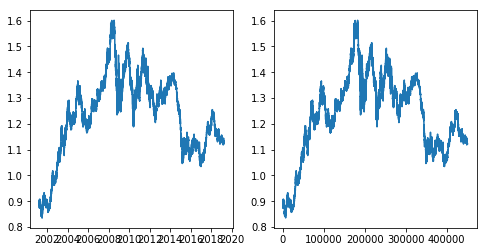

In [4]:
# Also, just for debugging purposes, let's visualize it
# Visualize range [i:j] of CLOSE price:
# Using x axis as dates at 1-hour pace
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df.CLOSE)
# Using continuous data
plt.subplot(1,2,2)
plt.plot(df.CLOSE.values)
# Both are valid

,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,TICKVOL,VOL,SPREAD
2019-03-15 14:15:00,1.13184,1.13209,1.13180,1.13195,1.131895,1.131947,1.131920,0.00011,855,4,804.0,0.0,0.0
2019-03-15 14:30:00,1.13195,1.13200,1.13169,1.13184,1.131895,1.131843,1.131870,-0.00011,870,4,575.0,0.0,0.0
2019-03-15 14:45:00,1.13185,1.13214,1.13177,1.13185,1.131850,1.131920,1.131903,0.00001,885,4,849.0,0.0,0.0
2019-03-15 15:00:00,1.13185,1.13196,1.13145,1.13171,1.131780,1.131707,1.131743,-0.00014,900,4,1023.0,0.0,0.0
2019-03-15 15:15:00,1.13171,1.13171,1.13109,1.13124,1.131475,1.131347,1.131438,-0.00047,915,4,1124.0,0.0,0.0


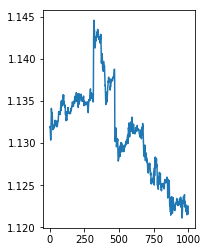

In [15]:
# Let's apply trend indentification on last 1000 samples
_df = df[-1000:].copy()
plt.subplot(1,2,2)
plt.plot(_df.CLOSE.values)
_df.head()

In [16]:
# let's add  indicators: ADX, MACD, Bollinger (bands, with, %b) and ZigZag
adx = talib.ADX(_df.HIGH, _df.LOW, _df.CLOSE, timeperiod=14)
_df['ADX'] = adx

macd, macdsignal, macdhist = talib.MACD(_df.CLOSE, fastperiod=12, slowperiod=26, signalperiod=9)
_df['MACD'] = macd
_df['MACD_SIG'] = macdsignal
_df['MACD_HIST'] = macdhist

upperband, middleband, lowerband = talib.BBANDS(_df.CLOSE, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
_df['BOLLINGER_HI'] = upperband
_df['BOLLINGER_MA'] = middleband
_df['BOLLINGER_LO'] = lowerband
_df['BOLLINGER_WIDTH'] = upperband - lowerband
boll_b = (_df.CLOSE - lowerband)/(upperband - lowerband)
boll_b[np.isnan(boll_b)]=0.5
boll_b[np.isinf(boll_b)]=0.5
_df['BOLLINGER_b'] = boll_b

# remove nans
_df.dropna(inplace=True)

zigzag_df, zigzag_x, zigzag_y = utils.ZIGZAG(_df, minbars=3, nan_value=0.0)
_df['ZIGZAG'] = zigzag_df.ZIGZAG
_df['ZIGZAG_ACTION'] = zigzag_df.ACTION

_df.head()


,OPEN,HIGH,LOW,CLOSE,OC2,HLC3,OHLC4,CLOSE_DIFF,HHMM,WEEKDAY,...,MACD,MACD_SIG,MACD_HIST,BOLLINGER_HI,BOLLINGER_MA,BOLLINGER_LO,BOLLINGER_WIDTH,BOLLINGER_b,ZIGZAG,ZIGZAG_ACTION
2019-03-15 22:30:00,1.13209,1.13217,1.13199,1.13201,1.13205,1.132057,1.132065,-0.00008,1350,4,...,-0.000013,0.000062,-0.000075,1.133427,1.132273,1.131119,0.002307,0.386001,1.13199,no-action
2019-03-15 22:45:00,1.13201,1.13230,1.13190,1.13219,1.13210,1.132130,1.132100,0.00018,1365,4,...,-0.000007,0.000048,-0.000055,1.133199,1.132205,1.131211,0.001987,0.492452,0.00000,no-action
2019-03-15 23:00:00,1.13219,1.13221,1.13179,1.13203,1.13211,1.132010,1.132055,-0.00016,1380,4,...,-0.000015,0.000036,-0.000050,1.133128,1.132168,1.131207,0.001920,0.428390,0.00000,no-action
2019-03-15 23:15:00,1.13203,1.13225,1.13192,1.13223,1.13213,1.132133,1.132108,0.00020,1395,4,...,-0.000005,0.000028,-0.000032,1.132946,1.132118,1.131289,0.001657,0.567879,0.00000,no-action
2019-03-15 23:30:00,1.13223,1.13296,1.13222,1.13271,1.13247,1.132630,1.132530,0.00048,1410,4,...,0.000042,0.000030,0.000011,1.132647,1.132075,1.131502,0.001145,1.055172,0.00000,high


In [17]:
zigzag_df[zigzag_df.ZIGZAG > 0.0]

,BOLLINGER_HI,BOLLINGER_MA,BOLLINGER_LO,ZIGZAG,ACTION
2019-03-15 22:30:00,1.133427,1.132273,1.131119,1.13199,no-action
2019-03-18 15:00:00,1.135933,1.134925,1.133916,1.13591,high
2019-03-18 20:15:00,1.135427,1.133964,1.132501,1.13246,low
2019-03-19 14:00:00,1.135844,1.135157,1.134470,1.13616,high
2019-03-19 17:30:00,1.136105,1.135210,1.134315,1.13386,low
2019-03-20 03:00:00,1.135685,1.135284,1.134883,1.13570,high
2019-03-20 04:15:00,1.135659,1.135133,1.134607,1.13428,low
2019-03-20 10:15:00,1.134878,1.134697,1.134516,1.13536,high
2019-03-20 11:45:00,1.135168,1.134609,1.134050,1.13355,low
2019-03-20 15:30:00,1.136406,1.135070,1.133733,1.13662,high


In [18]:
# let's plot price and indicators

_df0 = _df.reset_index(drop=True)

# selects zigzag points
_dfz = _df0[_df0.ZIGZAG > 0]

#--------------- FIRST CHART ---------------

# Create Candlestick
trace = go.Ohlc(x=_df0.reset_index()['index'],
                open=_df0.OPEN,
                high=_df0.HIGH,
                low=_df0.LOW,
                close=_df0.CLOSE,
                name='eurusd_M15')


# Creates 3 lines for the BollingerBands indicator
line_bbup = Scatter(
    x=_df0.reset_index()['index'],
    y=_df0.BOLLINGER_HI,
    name= 'UpperBand',
    line=scatter.Line(color='brown', dash='dash')
    )
line_bbmid = Scatter(
    x=_df0.reset_index()['index'],
    y=_df0.BOLLINGER_MA,
    name= 'MiddleBand',
    line=scatter.Line(color='brown', dash='dash')
    )
line_bbdn = Scatter(
    x=_df0.reset_index()['index'],
    y=_df0.BOLLINGER_LO,
    name= 'LowerBand',
    line=scatter.Line(color='brown', dash='dash')
    )
# Creates zigzag lines 
line_zigzag = go.Scatter(
    x=_dfz.reset_index()['index'], 
    y=_dfz.ZIGZAG,     
    name='zigzag', 
    line=scatter.Line(color='black', width=1))


#--------------- SECOND CHART ---------------
# Bollinger Bands width 
line_bbwidth = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.BOLLINGER_WIDTH,     
    name='BB_WIDTH', 
    line=scatter.Line(color='blue', width=2))


#--------------- THIRD CHART ---------------
# Bollinger Bands %b 
line_bb_b = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.BOLLINGER_b,     
    name='BB_%b', 
    line=scatter.Line(color='red', width=2))


#--------------- FOURTH CHART ---------------
# MACD 
line_macd = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.MACD,     
    name='MACD', 
    line=scatter.Line(color='blue', width=2))
line_macdsig = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.MACD_SIG,     
    name='MACD_sig', 
    line=scatter.Line(color='red', width=2))


#--------------- FIRTH CHART ---------------
# ADX 
line_adx = go.Scatter(
    x=_df0.reset_index()['index'], 
    y=_df0.ADX,     
    name='ADX', 
    line=scatter.Line(color='blue', width=2))



#--------------- BUILDER ---------------
fig = plotly.tools.make_subplots(rows=5, 
                                 cols=1, 
                                 subplot_titles=('Price&Zigzag', 'Bollinger Width', 'Bollinger %b', 'MACD', 'ADX'),
                                 shared_xaxes=True, 
                                 vertical_spacing=0.1)
fig.append_trace(trace, 1, 1)
fig.append_trace(line_zigzag, 1, 1)
fig.append_trace(line_bbwidth, 2, 1)
fig.append_trace(line_bb_b, 3, 1)
fig.append_trace(line_macd, 4, 1)
fig.append_trace(line_macdsig, 4, 1)
fig.append_trace(line_adx, 5, 1)
fig['layout'].update(height=800, title='Price & Indicators')
py.iplot(fig, filename='simple_ohlc')



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]
[ (5,1) x1,y5 ]



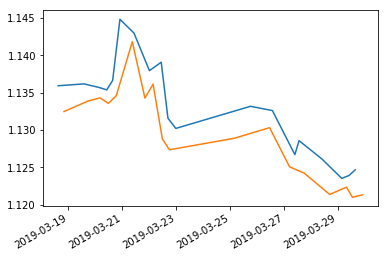

In [18]:
# let's analyze zigzags
zz_max = _df[(_df.ZIGZAG > 0) & (_df.ZIGZAG_ACTION=='high')]
zz_max.ZIGZAG.plot()

zz_min = _df[(_df.ZIGZAG > 0) & (_df.ZIGZAG_ACTION=='low')]
zz_min.ZIGZAG.plot()

In [72]:
# Let's extract some information

# count of continuous decreasing pairs
dec_p1 = dec_p2 = 0
for x in np.arange(3, len(zigzag_y))[::-1]:
  if zigzag_y[x] <= zigzag_y[x-2]:
    dec_p1 +=1
  else:
    break
for x in np.arange(3, len(zigzag_y))[::-1]:
  if zigzag_y[x-1] <= zigzag_y[x-3]:
    dec_p2 +=1
  else: 
    break
print('decp1={}, decp2={}'.format(dec_p1, dec_p2))


decp1=0, decp2=1


In [73]:
# count of continuous increasing pairs
inc_p1 = inc_p2 = 0
for x in np.arange(3, len(zigzag_y))[::-1]:
  if zigzag_y[x] >= zigzag_y[x-2]:
    inc_p1 +=1
  else:
    break
for x in np.arange(3, len(zigzag_y))[::-1]:
  if zigzag_y[x-1] >= zigzag_y[x-3]:
    inc_p2 +=1
  else: 
    break
print('incp1={}, incp2={}'.format(inc_p1, inc_p2))


incp1=1, incp2=0


In [68]:
maxs      

[0.8991, 0.8977, 0.9052, 0.9079, 0.9093, 0.8987, 0.9021, 0.9051]

In [67]:
# builds decreasing max
dec_max = []
for x in range(len(maxs)-1):  
  if x==0 and x >= max(maxs[x:]):
    dec_max.append(mins[x])
  elif x>0 and x >= max(maxs[x:]) and x <= min(maxs[:x]):
    dec_max.append(maxs[x])
      
dec_max                   

[]



As said, this model will predict an estimation of High and Low prices for next session. To achieve it, it will predict the price movement from the current close price. So, knowing the current close time and the prediction movement, it will extract the real High,Low prices.

So, both outputs could be expressed with these equations:

PREDICTION_HIGH(t+1) = PRICE_HIGH(t+1) - CLOSE(t)

PREDICTION_LOW(t+1) = PRICE_LOW(t+1) - CLOSE(t)


In [ ]:
# function to generate predictions as explained above
def define_outputs(df):  
  df['OUT_HIGH'] = df.HIGH - df.CLOSE.shift(1)
  df['OUT_LOW'] = df.LOW - df.CLOSE.shift(1)
  return df

# Add both outputs to df dataframe and check first rows (also remove NaNs)
df = define_outputs(df)
df.dropna(inplace=True)
df.head()

In [ ]:
# Visualization of all columns: input features and target predictions
rows = (df.shape[1] / 4) + 1
plt.figure(figsize = (12,50))
for c in df.columns:
  i = df.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df[c])
  plt.legend([c])
  

### Data preprocessing

This model will predict price movement one timestep ahead, from a loopback window of the last 4 timesteps: 

(t-3), (t-2), (t-1), (t) ==> (t+1)

LSTM cells require input features and target outputs to be in a proper format:

- Input features shape: (num_samples, num_loopback_timesteps, num_input_features)
- Output target shape: (num_outputs * num_prediction_timesteps)

To adapt data contained in df dataframe into these sets, I use function 'series_to_supervised' contained in python file 'MyUtils.py'. You can check how it works there.


In [ ]:
# Setup:

# Num outputs to predict
num_outputs = 2

# Num input features
num_inputs = len(df.columns) - num_outputs

# Num loopback timesteps
n_in = 4

# Num timesteps to predict
n_out = 1

# Flag to remove NaN values from  df dataframe
dropnan = True

# Run the preprocessor and get a new dataframe 'df_nn'
df_nn = utils.series_to_supervised(df, num_inputs, num_outputs, n_in, n_out, dropnan)

# Check the result
print(df_nn.shape)
df_nn.head()

In [ ]:
# DATA DEBUGGING:
# Now I use an auxiliar temporal dataframe '_df' to check if target outputs are calculated correctly. I check if 'next_high' 
# column has the same content as 'HIGH(t)' shifted 1 timestemp in the future.
_df = df_nn[['HIGH(t-1)','HIGH(t)','LOW(t-1)','LOW(t)','CLOSE(t-1)', 'CLOSE(t)','OUT_HIGH(t+1)']].head(10).copy()
_df['next_high'] = _df['CLOSE(t)']+ _df['OUT_HIGH(t+1)']
_df

### Data normalization

A general preprocessing operation in Neural Networks is data normalization, in this case, as LSTM cells contains a 'tanh' cell, I will normalize all features in range [-1,+1].

I will save the scaler for further use when de-normalization process is required later on model validation. I use 'MinMaxScaler' from Scikit-learn library. For this purpose I use 'normalize_data' function from MyUtils.py file:

In [ ]:
#### Data normalization. Get the scaler (save a copy on disk for later use) and a new normalized dataframe: dfnorm
dfnorm, scaler = utils.normalize_data(df_nn, feat_range = (-1,1), csv_to_save=None, scaler_to_save='../scaler_data/scaler.data')
# check result
dfnorm.describe()

## 3 RNN model construction

First of all, I like to say that I will use Keras as fronted over Tensorflow, to build a stacked LSTM network.

I use function 'build_lstm_net' in MyUtils.py file (check it there if curious). It requires different arguments: num_inputs, num_outputs, loopback and predicted timestemps, number of LSTM layers, ...

In first place  I will execute a cross validation phase, using 'Kfolds' from Scikit-learn to get a first impression about the model. I'll generate 5 different models.


### Cross validation

dfnorm dataframe is used to get train-test in-out pairs. LSTM model is:

- 3 stacked LSTM layers with 64 neurons each.
- 1 Dense hidden layer with 128 neurons.
- 1 Dense output layer with 2 neurons (one per output)
- Dropout after each layer to improve generalization and avoid overfitting


In [ ]:
# split into input (X) and output (Y) variables
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
# define 5-fold cross validation test harness
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
i=0
for train, test in kfold.split(X, Y):
  # create model
  model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'weights_0412_m'+str(i)+'.hd5')
  i += 1
  # Fit the model
  x = X[train]
  x = x.reshape(x.shape[0], n_in, num_inputs)
  utils.fit(model, x, Y[train], num_inputs, n_in, num_epochs=5, callbacks=callbacks, batchsize=32)  
  # evaluate the model
  x = X[test]
  scores = utils.test_evaluation(model, x, Y[test], num_inputs, n_in)
  x = x.reshape(x.shape[0], n_in, num_inputs)
  scores = model.evaluate(x, Y[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

As this model seems to be raise good results, I will train with a whole train-test dataset.

### Model training

In this case, I will use 'dfnorm' dataframe and get 80% (around 88000 samples) for training and 20% (around 22000 samples) for validation. I'll use 'prepare_training_data' and 'fit' functions from MyUtils.py file:

In [ ]:
# Prepare data for train-test
x_train,y_train,x_test,y_test = utils.prepare_training_data(dfnorm, num_inputs * n_in, 0.8)
print('x_train:', x_train.shape, 'y_train', y_train.shape)
print('x_test:', x_test.shape, 'y_test', y_test.shape)


In [ ]:
# Build the RNN model with same configuration
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 3,2,64,128,'../hd5_data/weightsH4_3.2.64.128.hd5')

In [ ]:
# Setup:

# Training epochs
num_epochs = 30
# Batch size
batchsize = 32
# Ratio validation-training (20%)
val_ratio = 0.2
# Enable data shuffling
shuffle = True
# Enable result plotting
plot_results = True
# Start training
result = utils.fit(model, x_train, y_train, num_inputs, n_in, num_epochs, callbacks, batchsize, val_ratio, shuffle, plot_results, verbose=2)

In [ ]:
# Save model weights on disk, as HDF5 file
model.save_weights('../hd5_data/weightsH4_3.2.64.128.hd5')

### Model verification

Once trained, let's check its behaviour with new data. Function 'test_rmse' in MyUtils.py executes the test and returns the RMSE result. A callback 'out_builder' is needed to de-normalize data to calculate RMSE.

In [ ]:
# column selection for 'out_builder' callback
ih = df_nn.columns.get_loc('OUT_HIGH(t+1)')  
il = df_nn.columns.get_loc('OUT_LOW(t+1)')
ic = df_nn.columns.get_loc('CLOSE(t)')
  
# Callback to build de-normalized output data from normalized predictions
def out_builder(xy,xyhat):
  return np.asarray([xy[ih]+xy[ic],xy[il]+xy[ic]]), np.asarray([xyhat[ih]+xyhat[ic],xyhat[il]+xyhat[ic]])
  
# Executes test process and visualizes RMSE result
scores, targets, preds, rmse = utils.test_rmse(model, x_test, y_test, num_inputs, n_in, num_outputs, n_out, scaler, out_builder, True)

In [ ]:
# Dataframe update:

# Reshape results into np.arrays
atgt = np.asarray(targets)
apreds = np.asarray(preds)
armse = np.asarray(rmse)

# Build a new dataframe named 'df_predict' with prediction results.
df_predict = df_nn[x_train.shape[0]:].copy()
#... add predictions...
df_predict['PREDICT_HIGH'] = apreds[:,0]
df_predict['PREDICT_LOW'] = apreds[:,1]

#... add targets...
df_predict['TARGET_HIGH'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)'] 

#... add some data-debugging columns to validate results
df_predict['TARGET_HIGH_CHECK'] = atgt[:,0]
df_predict['TARGET_LOW_CHECK'] = atgt[:,1]

#... add RMSE error
df_predict['RMSE'] = armse[:]

# Visualize first rows for visual debugging
df_predict.head()

Now I carry on a visual inspection of results obtained. I can range the visualization plot to zoom in or out.

Target range (real range between high and low prices) is coloured in grey, while predicted range (area between predicted high and low) is coloured in yellow.

In [ ]:
plt.figure(figsize=(16,16))
i=-10
x = np.arange(10)
y1 = df_predict['TARGET_HIGH'].values[i:]
y2 = df_predict['TARGET_LOW'].values[i:]
y3 = df_predict['PREDICT_HIGH'].values[i:]
y4 = df_predict['PREDICT_LOW'].values[i:]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])


As can be seen, there exist a small prediction error. In general, predicted range between High and Low prices as greater than real High-Low range.


### Next steps

Once verified that prediction is valid for my purposes, it's time to build a dataframe for the next stage: A3C-LSTM agent.

In this new stage, the agent will require real time market data (bars, quotes, account info and predictions) to start its training process as a RL problem.

Now we are going to build a dataframe (only with bars, targets, predictions) for this next stage:

In [ ]:
# split historic data into input (X) and output (Y) variables and executes predictions
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]
predictions = model.predict(X.reshape(X.shape[0], n_in, num_inputs), batch_size=1)

In [ ]:
# let's copy dfnorm and add predictions as new columns
df_predict = dfnorm.copy()
df_predict['OUT_HIGH(t+1)'] = predictions[:,0]
df_predict['OUT_LOW(t+1)']  = predictions[:,1]
df_predict.tail()

In [ ]:
# de-normalize data
df_predict = utils.denormalize_data(df_predict, scaler)
df_predict.tail()

In [ ]:
# Add new columns for expected targets
df_predict['TARGET_HIGH'] = df_nn['OUT_HIGH(t+1)'] 
df_predict['TARGET_LOW'] = df_nn['OUT_LOW(t+1)'] 

#... calculate RMSE error between targets and predictions
df_predict['RMSE'] = df_predict.apply(lambda row: math.sqrt(sk.mean_squared_error(np.asarray([row['TARGET_HIGH'], row['TARGET_LOW']]), np.asarray([row['OUT_HIGH(t+1)'], row['OUT_LOW(t+1)']]), multioutput = 'uniform_average')), axis=1)

# add new columns to get targets and predictions as absolute price values
df_predict['PREDICT_HIGH_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_HIGH(t+1)']
df_predict['PREDICT_LOW_PRICE'] = df_predict['CLOSE(t)'] + df_predict['OUT_LOW(t+1)']
df_predict['TARGET_HIGH_PRICE'] = df_predict['CLOSE(t)'] + df_predict['TARGET_HIGH']
df_predict['TARGET_LOW_PRICE'] = df_predict['CLOSE(t)'] + df_predict['TARGET_LOW']

#... and calculate RMSE error using absolute price values
df_predict['RMSE_PRICE'] = df_predict.apply(lambda row: math.sqrt(sk.mean_squared_error(np.asarray([row['TARGET_HIGH_PRICE'], row['TARGET_LOW_PRICE']]), np.asarray([row['PREDICT_HIGH_PRICE'], row['PREDICT_LOW_PRICE']]), multioutput = 'uniform_average')), axis=1)

df_predict.head()

In [ ]:
# Select only required columns for next stage
df_predict = df_predict[['OPEN(t)','HIGH(t)','LOW(t)','CLOSE(t)','OUT_HIGH(t+1)','OUT_LOW(t+1)','TARGET_HIGH','TARGET_LOW','RMSE','PREDICT_HIGH_PRICE','PREDICT_LOW_PRICE','TARGET_HIGH_PRICE','TARGET_LOW_PRICE', 'RMSE_PRICE']]
df_predict.tail()                      

In [ ]:
# Show targets (grey area) vs predictions (yellow area)
plt.figure(figsize=(16,16))
# Zoom in range to plot (can be changed)
i=-20
x = np.arange(-i)
y1 = df_predict['TARGET_HIGH_PRICE'].values[i:]
y2 = df_predict['TARGET_LOW_PRICE'].values[i:]
y3 = df_predict['PREDICT_HIGH_PRICE'].values[i:]
y4 = df_predict['PREDICT_LOW_PRICE'].values[i:]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])

In [ ]:
# Show RMSE errors
plt.subplot(1,2,1)
plt.plot(df_predict['RMSE'], color='b')
plt.legend(['RMSE_prediction'])
plt.subplot(1,2,2)
plt.plot(df_predict['RMSE_PRICE'], color = 'r')
plt.legend(['RMSE_price'])

In [ ]:
# Save file on disk
df_predict.to_csv('../csv_data/EURUSD_H4_predictions.csv', sep=';')
print('File saved!')